In [99]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imgaug as ia
import torch
import pandas as pd
import os
import glob

In [169]:
def bb_midpoint_to_corner(bb):
    label = bb[0]
    x1 = bb[1] - bb[3]/2
    x2 = bb[1] + bb[3]/2
    y1 = bb[2] - bb[4]/2
    y2 = bb[2] + bb[4]/2
    # A: area will only be used for sorting
    area = bb[3]*bb[4]
    corner_list = [label, x1, x2, y1, y2, area]
    return np.array(corner_list)

def open_yolo_sort(path, image_name):
    try:
        image = cv2.imread(path + image_name)
        shape = image.shape
        width = shape[1]
        height = shape[0]
        #print(width, height)
        label = path + os.path.splitext(image_name)[0] + ".txt"
        boxes = np.genfromtxt(label, delimiter=' ')
        bb = boxes
        # reshaping the np array is necessary in case a file with a single box is read
        boxes = boxes.reshape(boxes.size//5, 5)
        #print(boxes.shape)
        boxes = np.apply_along_axis(bb_midpoint_to_corner, axis=1, arr=boxes)
        # A: sorting by area
        boxes = boxes[boxes[:, 5].argsort()]
        # A: reversing the sorted list so bigger areas come first
        boxes = boxes[::-1]
        return image, boxes, width, height
    except Exception as e:
        print(e)
        print(image_name)
        return image, None, None, None

def create_segclass(image_path, save_path, image_name):
    image, bb, w, h = open_yolo_sort(image_path, image_name)
    image_copy = image.copy()*0 
    if bb is not None:       
        for label, x1, x2, y1, y2, area in bb:
            # A: the white outline with four pixels of thickness
            #cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), (255, 255, 255), 4)
            # A: the class coded filing, specified by -1
            cv2.rectangle(image_copy, (int(x1*w), int(y1*h)), (int(x2*w), int(y2*h)), colors[int(label)], -1)
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] + ".png", image_copy)
    else:
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] +".png", image_copy)
        
colors = [
         (0, 0, 0),       # Background
         (162, 0, 255),   # Chave seccionadora lamina (Aberta)
         (97, 16, 162),   # Chave seccionadora lamina (Fechada)
         (81, 162, 0),    # Chave seccionadora tandem (Aberta)
         (48, 97, 165),   # Chave seccionadora tandem (Fechada)
         (121, 121, 121), # Disjuntor
         (255, 97, 178),  # Fusivel
         (154, 32, 121),  # Isolador disco de vidro
         (255, 255, 125), # Isolador pino de porcelana
         (162, 243, 162), # Mufla
         (143, 211, 255), # Para-raio
         (40, 0, 186),    # Religador
         (255, 182, 0),   # Transformador
         (138, 138, 0),   # Transformador de Corrente (TC)
         (162, 48, 0)]    # Transformador de Potencial (TP)

encoded_colors = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
class_names =     [ "Background",
                    "Chave seccionadora lamina (Aberta)",
                    "Chave seccionadora lamina (Fechada)",
                    "Chave seccionadora tandem (Aberta)",
                    "Chave seccionadora tandem (Fechada)",
                    "Disjuntor",
                    "Fusivel",
                    "Isolador disco de vidro",
                    "Isolador pino de porcelana",
                    "Mufla",
                    "Para-raio",
                    "Religador",
                    "Transformador",
                    "Transformador de Corrente (TC)",
                    "Transformador de Potencial (TP)"]
colors_rgb = []
for c in colors:
    colors_rgb.append((c[2], c[1], c[0]))

In [187]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from PIL import Image

# A: Needed to encode the colors as (M, N) labels for the loss.
# Since the loss can't be calculated with a tensor of shape 
# [batch_size, height, width, channels] if the three channels are
# present, we need this to be able to encode the rgb class colors
# into a single value to represent them.
def get_labels():
    """Load the mapping that associates classes with label colors.
       Our electrical substation dataset has 14 objects + background.
    Returns:
        np.ndarray with dimensions (15, 3)
    """
    return np.asarray([(0, 0, 0),       # Background
                       (162, 0, 255),   # Chave seccionadora lamina (Aberta)
                       (97, 16, 162),   # Chave seccionadora lamina (Fechada)
                       (81, 162, 0),    # Chave seccionadora tandem (Aberta)
                       (48, 97, 165),   # Chave seccionadora tandem (Fechada)
                       (121, 121, 121), # Disjuntor
                       (255, 97, 178),  # Fusivel
                       (154, 32, 121),  # Isolador disco de vidro
                       (255, 255, 125), # Isolador pino de porcelana
                       (162, 243, 162), # Mufla
                       (143, 211, 255), # Para-raio
                       (40, 0, 186),    # Religador
                       (255, 182, 0),   # Transformador
                       (138, 138, 0),   # Transformador de Corrente (TC)
                       (162, 48, 0)]    # Transformador de Potencial (TP)
                      )

def decode_target(label_mask):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
    Returns:
        (np.ndarray): the resulting decoded color image.
    """
    label_colors = get_labels()
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for l in range(0, len(label_colors)):
        r[label_mask == l] = label_colors[l, 0]
        g[label_mask == l] = label_colors[l, 1]
        b[label_mask == l] = label_colors[l, 2]
    image = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    image[:, :, 0] = r
    image[:, :, 1] = g
    image[:, :, 2] = b
    return image.astype('uint8')

# A: in order for the mask to go through the loss function, the classes need to be
# represented as a single value, opposed to three channels.
def encode_target(mask):
    """Encode segmentation label images as classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the classes are encoded as colors.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int8)
    for i, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = i
    label_mask = label_mask.astype(int)
    return label_mask

# https://www.programcreek.com/python/?code=1044197988%2FSemantic-segmentation-of-remote-sensing-images%2FSemantic-segmentation-of-remote-sensing-images-master%2FCRF.py
def crf(original_image, annotated_image):
    """Applies the denseCRF (Conditional Random Fields) algorithm.
    Args:
        original_image (np.ndarray) : the original image of dimension (M, N, 3).
        annotated_image (np.ndarray): associated segmentation mask 
        image of dimension (M, N, 3), in which the classes are encoded as colors.
    Returns:
        (np.ndarray): segmentation mask of dimension (M, N, 3) after the denseCRF
        filtered the fully connected components.
    """
    # Convert the annotation RGB color to a single integer
    annotated_label = encode_target(annotated_image)
     # Convert 32-bit integer colors to 0, 1, 2, ... labels.
    og_colors, labels = np.unique(annotated_label, return_inverse=True)
#     print(og_colors)
    n_labels = len(set(labels.flat))
    
    # Setting up the CRF model
    #if use_2d :
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=original_image,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
    # end of if  
    #Run Inference for 5 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)
    colors, labels = np.unique(MAP, return_inverse=True)
    #print(len(colors))
#     print(colors)
    # C Convert the map (label) back to the corresponding color and save the image.
    # Note that there is no more "unknown" here, no matter what we had in the first place.
    # A: reshaping the MAP into the dimensions of the image
    MAP = MAP.reshape(original_image.shape[0], original_image.shape[1])
    MAP_copy = MAP.copy()
    # A: this, essentially, is an encoder for the encoder. og_colors has the indexes that go
    # with the decoder. However, the argmax doesn't keep that value, instead replacing it with
    # 0... number of unique colors. But the order is retained, so by mapping the index of each
    # unique color with the og_colors one, it's possible to go back to the correct indexes that
    # will then decode into the associated BGR mask color.
    for l in range(0, len(og_colors)):
        MAP_copy[MAP == l] = og_colors[l]
    colors, labels = np.unique(MAP_copy, return_inverse=True)
#     print(colors)
    MAP_copy = decode_target(MAP_copy)

    
    return MAP_copy

In [193]:
image_path = "/home/jovyan/work/yolo_og/yolov3/Data/14_classes/valid/"
seg_path   = "/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r10_prediction_valid/"
box_path   = "/home/jovyan/work/yolo_og/yolov3/Data/14_classes/segmentation_valid/"
save_path  = "/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r1_postprocess_valid/"
scp_path   = "./test_images/"

DISPLAY = True
SAVING = False

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("Created dir " + save_path)

file_list = os.path.join(os.path.join(image_path, "*.*"))
# using glob to get the image names, since they can have more than one extension
file_list = glob.glob(file_list)
label_list = []
image_list = []
for file in file_list:
    if ".txt" not in file:
        file = file.split("/")[-1]
        #file = os.path.splitext(file)[0]
        image_list.append(file)

for image_name in image_list[0:1]:
    png_compression = 9
    box_image = cv2.imread(box_path + os.path.splitext(image_name)[0] + ".png")
    box_image = cv2.cvtColor(box_image, cv2.COLOR_BGR2RGB)
    image, seg_image, cut_image = box_method(image_path, seg_path, save_path, image_name)
    if SAVING:
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] +".png", cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite(scp_path+"cut_image.png", cv2.addWeighted(cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
    cv2.imwrite(scp_path+"original.png", image)

    #cut_image = cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB)
    # A: displaying the images
    if DISPLAY:
        alpha = 0.5
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(221)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        ax = fig.add_subplot(222)
        #ax.imshow(box_image)
        ax.imshow(cv2.addWeighted(cut_image, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
        plt.axis('off')
#         ax = fig.add_subplot(223)
#         ax.imshow(cv2.addWeighted(dense, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
#         plt.axis('off')
#         ax = fig.add_subplot(224)
#         kernel = np.ones((10,10),np.uint8)
#         cv2.imwrite(scp_path+"dense_image.png", cv2.addWeighted(cv2.cvtColor(dense, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
#         dense = cv2.morphologyEx(dense, cv2.MORPH_CLOSE, kernel, iterations=1)
#         dense = cv2.morphologyEx(dense, cv2.MORPH_OPEN, kernel, iterations=1)
#         cv2.imwrite(scp_path+"morph_image.png", cv2.addWeighted(cv2.cvtColor(dense, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
#         ax.imshow(cv2.addWeighted(dense, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
#         plt.axis('off')
        plt.show()
        plt.clf()

/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r10_prediction_valid/20210811_091428.png


KeyboardInterrupt: 

In [208]:
def box_method(image_path, seg_path, save_path, image_name):
    #print(image_name)
    image, bb, w, h = open_yolo_sort(image_path, image_name)
    seg_image = cv2.imread(seg_path + os.path.splitext(image_name)[0] + ".png")
    print(seg_path + os.path.splitext(image_name)[0] + ".png")
    seg_image = cv2.cvtColor(seg_image, cv2.COLOR_BGR2RGB)
    image_copy = seg_image.copy()*0 
    presentation = 0
    if bb is not None:       
        for label, x1, x2, y1, y2, area in bb:
        # 1. Any pixel outside the box annotations is reset to background label.
        # A: getting the scaled version of the normalized coordinates.
        # A: this method will also get rid of any false positives from DeepLab.
            sx1 = int(x1*w)
            sx2 = int(x2*w)
            sy1 = int(y1*h)
            sy2 = int(y2*h)
            # A: this +1 is because the background color is the 0th index in the color
            # list, but this label did not exist in YOLO. Thus we are shifting every
            # label by 1.
            label = int(label)+1
            
            # 2. If the area of a segment is too small compared to its corresponding
            # bounding box (e.g. IoU< 50%), the box area is reset to its initial label
            # (fed in the first round). This enforces a minimal area.
            # A: We'll check for 2. before applying 1., since if the condition is true,
            # the whole box area will needs to be set with the label color. This will be
            # done by counting the total number of pixels of that color in the seg_mask.
            # If it's less than half the total area of that bounding box, the whole area
            # will be set to that label color.
            slice_area = seg_image[sy1:sy2, sx1:sx2].copy()
            # the area is all pixels of the bounding box
            area = int((sx2 - sx1)*(sy2 - sy1))
            color_mask = np.all(slice_area == colors[label], axis=-1)

            count = int(np.sum((slice_area == colors[label]))/3) 
            if DISPLAY:
                if presentation < -1:
                    fig = plt.figure(figsize=(10, 10))
                    ax = fig.add_subplot(131)
                    ax.imshow(cv2.cvtColor(image[sy1:sy2, sx1:sx2], cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    ax = fig.add_subplot(133)
                    ax.imshow(1 - color_mask, cmap='Blues')
                    plt.axis('off')
                    ax = fig.add_subplot(132)
                    ax.imshow(slice_area)
                    plt.axis('off')
                    plt.show()
                    plt.clf()
                    print(f"Area: {area}, Color: {count}")
                    presentation += 1

            # A: This is where the second condition is effectly applied. The entire bounding box
            # area is set to that label color, if the pixel count of that label is smaller
            # than 50% of the area.
            # Most classes will use 50% of the IoU.
            if label > 6 or label == 5:
                if(count < int(area/3)):
                    image_copy[sy1:sy2, sx1:sx2] = colors[label]
                # A: By default, any pixel not within a bounding box is black.
                # To make 1. happen, we'll work within the constraints of the original bounding
                # boxes, so that false positives are removed and the prediction blobs can't be
                # bigger than the bounding boxes. Then, within those constraints, the pixels
                # coordinates that share the correct label color will be set to that color.
                # Do not forget that images are y, x.
                else:
                    image_copy[sy1:sy2, sx1:sx2][np.where(np.all(seg_image[sy1:sy2, sx1:sx2] == colors[label], axis=-1))[:2]] = colors[label]  
            # A: for classes that it's known that the object will be much smaller than the original
            # bounding box, 1/2 of the area is too much. 1/3 will be used to allow the model to
            # shrink those objects towards something.
            else:
                if(count < int(area/4)):
                    image_copy[sy1:sy2, sx1:sx2] = colors[label]
                else:
                    image_copy[sy1:sy2, sx1:sx2][np.where(np.all(seg_image[sy1:sy2, sx1:sx2] == colors[label], axis=-1))[:2]] = colors[label] 
          
            #x_test = mean_substraction(copy.deepcopy(image))
#         dense = crf(image, image_copy)
        #print(type(dense))
        #print(dense.shape)
        #cv2.imwrite("test.png", cv2.cvtColor(dense, cv2.COLOR_RGB2BGR))
#         fig = plt.figure(figsize=(15,15))
#         ax = fig.add_subplot(121)
#         ax.imshow(dense)
#         plt.axis('off')
#         plt.clf()
            #crf_mask = dense_CRF_.run_dense_CRF()
        return image, seg_image, image_copy#, dense
    else:
        print(f"Empty image: {image_name}")
        return image, image*0, image*0, image*0
            

    # 3. As it is common practice among semantic labelling methods, we filter
    # the output of the network to better respect the object boundaries.
    #(We use DenseCRFwith the DeepLabv1 parameters ). 
    # In our weakly supervised scenario, boundary-aware filtering is particu
    # larly useful to improve objects delineation.
    

/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r10_prediction_valid/20210811_094557.png


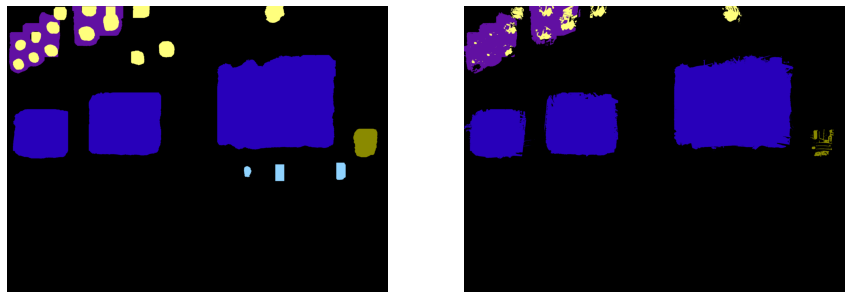

Area: 647808, Class pixels: 589110
Correct label: Religador (11)


<Figure size 432x288 with 0 Axes>

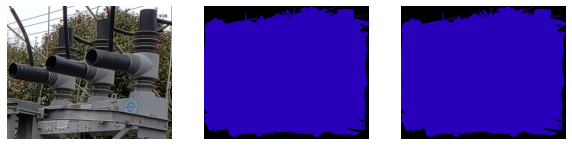

Area: 263654, Class pixels: 246896
Correct label: Religador (11)


<Figure size 432x288 with 0 Axes>

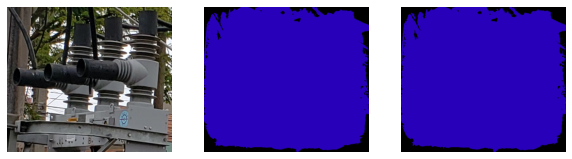

Area: 160545, Class pixels: 146536
Correct label: Religador (11)


<Figure size 432x288 with 0 Axes>

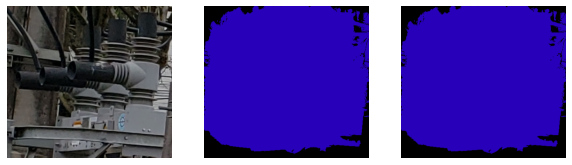

Area: 64377, Class pixels: 43929
Correct label: Chave seccionadora lamina (Fechada) (2)


<Figure size 432x288 with 0 Axes>

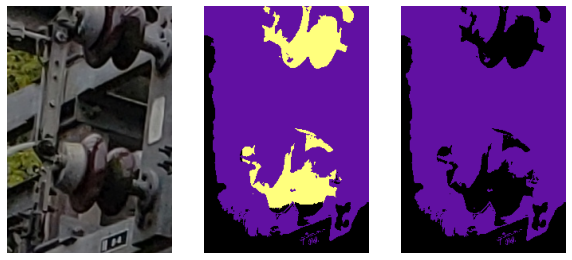

Area: 62376, Class pixels: 38769
Correct label: Chave seccionadora lamina (Fechada) (2)


<Figure size 432x288 with 0 Axes>

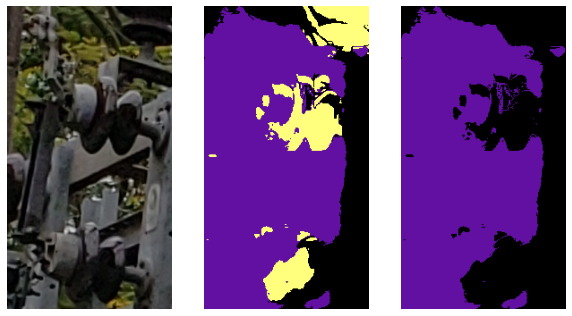

Area: 57270, Class pixels: 52819
Correct label: Chave seccionadora lamina (Fechada) (2)


<Figure size 432x288 with 0 Axes>

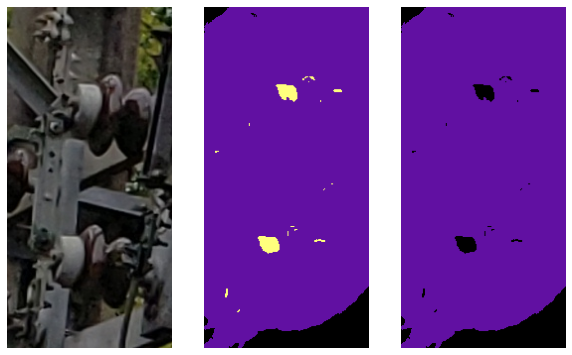

Area: 49880, Class pixels: 23217
Correct label: Transformador de Corrente (TC) (13)


<Figure size 432x288 with 0 Axes>

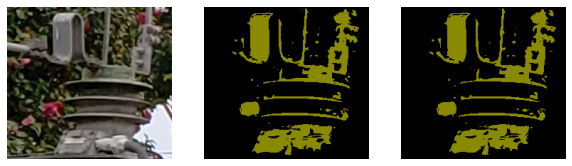

Area: 47829, Class pixels: 38481
Correct label: Chave seccionadora lamina (Fechada) (2)


<Figure size 432x288 with 0 Axes>

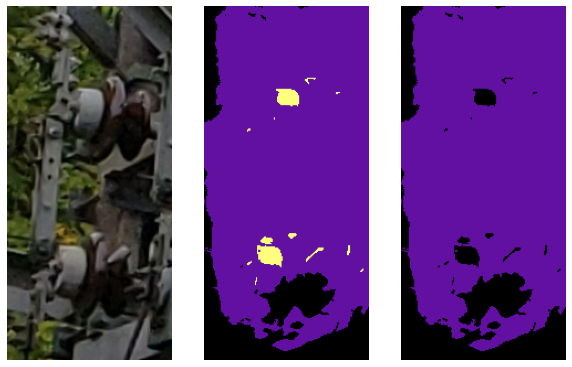

Area: 45450, Class pixels: 23751
Correct label: Chave seccionadora lamina (Fechada) (2)


<Figure size 432x288 with 0 Axes>

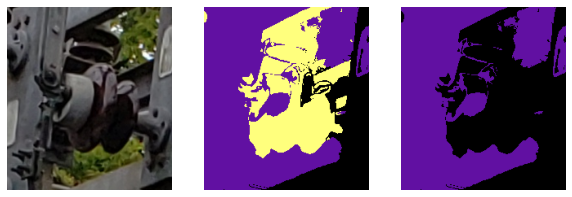

Area: 21488, Class pixels: 10473
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

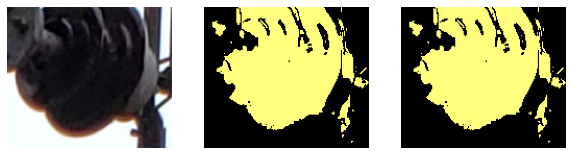

Area: 15875, Class pixels: 0
Object not detected by denseCRF. Adding original from segmentation mask.


<Figure size 432x288 with 0 Axes>

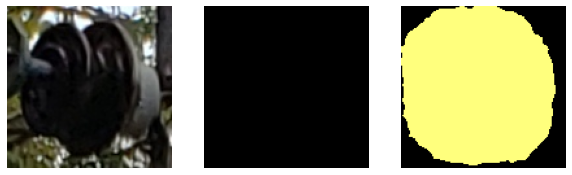

Area: 15996, Class pixels: 9333
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

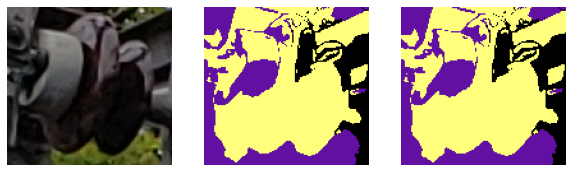

Area: 15867, Class pixels: 4379
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

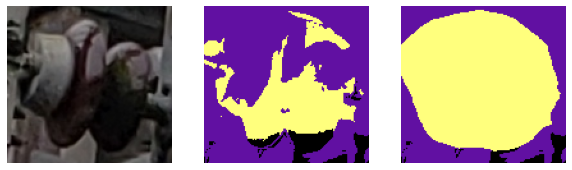

Area: 14036, Class pixels: 0
Object not detected by denseCRF. Adding original from segmentation mask.


<Figure size 432x288 with 0 Axes>

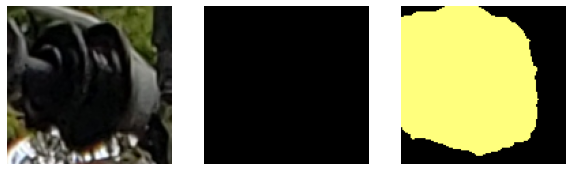

Area: 11978, Class pixels: 2118
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

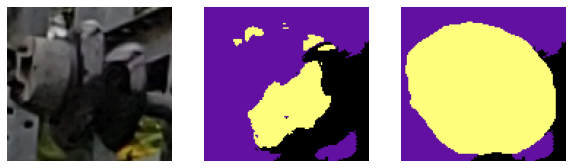

Area: 11978, Class pixels: 3747
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

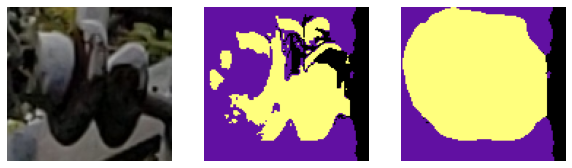

Area: 12060, Class pixels: 6374
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

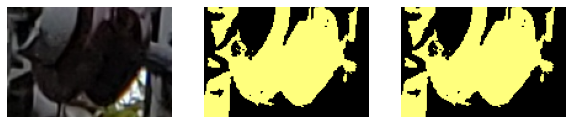

Area: 10508, Class pixels: 0
Object not detected by denseCRF. Adding original from segmentation mask.


<Figure size 432x288 with 0 Axes>

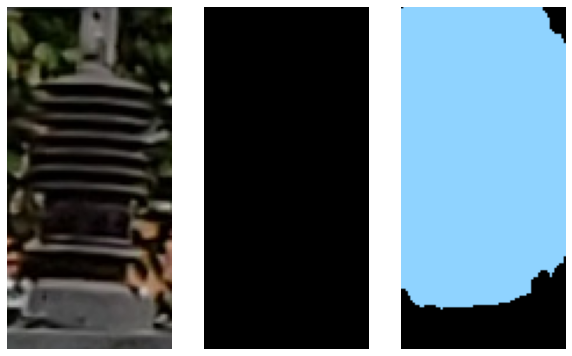

Area: 10404, Class pixels: 322
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

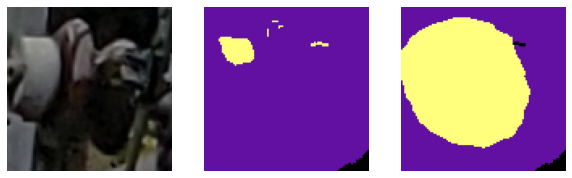

Area: 10266, Class pixels: 4363
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

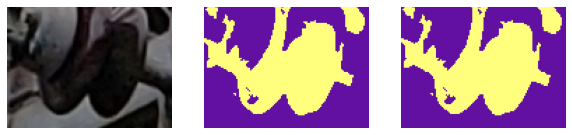

Area: 9801, Class pixels: 6032
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

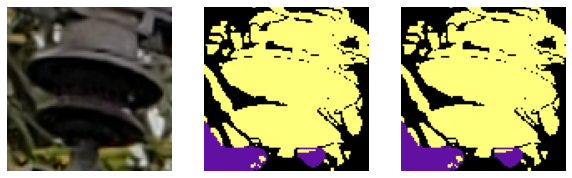

Area: 9400, Class pixels: 302
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

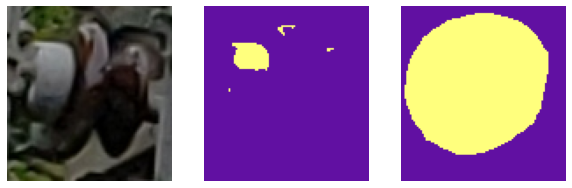

Area: 9300, Class pixels: 473
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

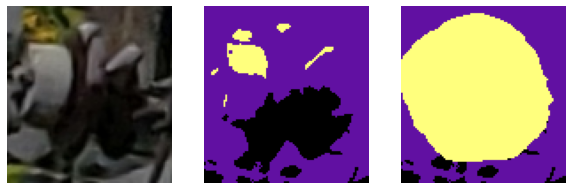

Area: 9207, Class pixels: 319
Correct label: Isolador pino de porcelana (8)
IoU too small. Replacing.


<Figure size 432x288 with 0 Axes>

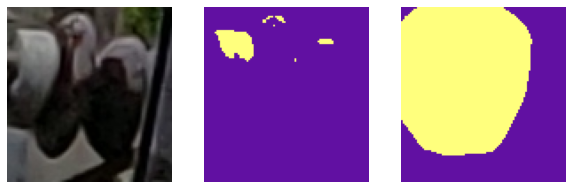

Area: 8568, Class pixels: 0
Object not detected by denseCRF. Adding original from segmentation mask.


<Figure size 432x288 with 0 Axes>

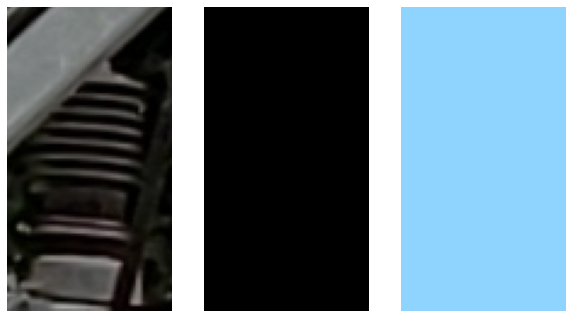

Area: 7564, Class pixels: 0
Object not detected by denseCRF. Adding original from segmentation mask.


<Figure size 432x288 with 0 Axes>

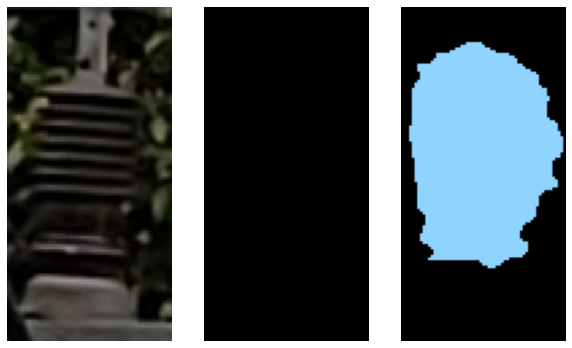

Area: 5402, Class pixels: 3984
Correct label: Isolador pino de porcelana (8)


<Figure size 432x288 with 0 Axes>

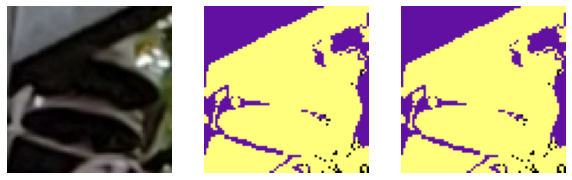

<Figure size 432x288 with 0 Axes>

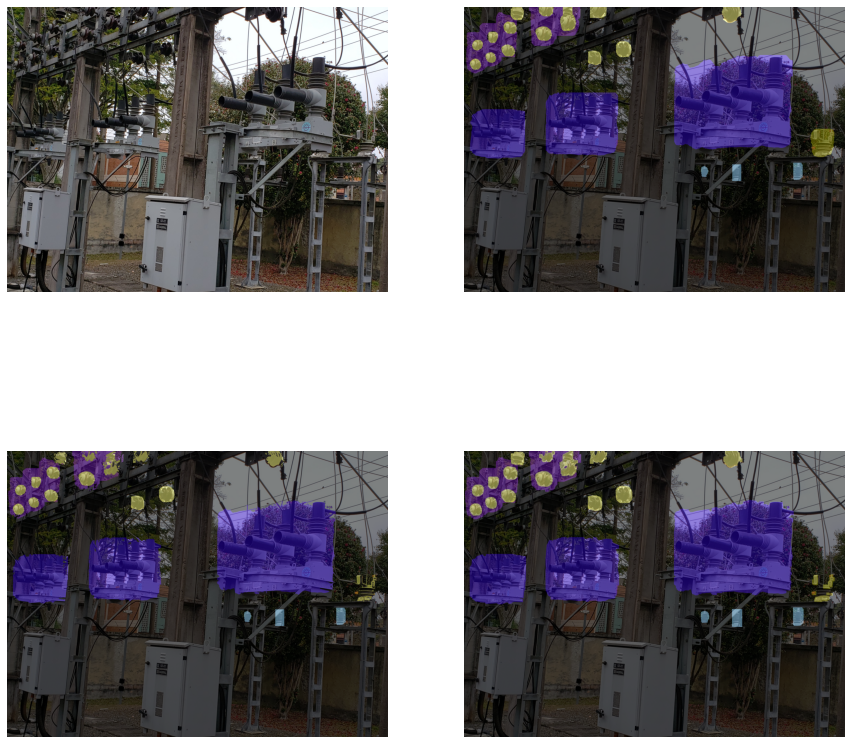

<Figure size 432x288 with 0 Axes>

In [209]:
image_path = "/home/jovyan/work/yolo_og/yolov3/Data/14_classes/valid/"
seg_path   = "/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r10_prediction_valid/"
box_path   = "/home/jovyan/work/yolo_og/yolov3/Data/14_classes/segmentation_valid/"
save_path  = "/home/jovyan/work/deeplab/DeepLabV3Plus-Pytorch/r1_postprocess_valid/"
scp_path   = "./test_images/"

DISPLAY = True
SAVING = False

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    print("Created dir " + save_path)

file_list = os.path.join(os.path.join(image_path, "*.*"))
# using glob to get the image names, since they can have more than one extension
file_list = glob.glob(file_list)
label_list = []
image_list = []
for file in file_list:
    if ".txt" not in file:
        file = file.split("/")[-1]
        #file = os.path.splitext(file)[0]
        image_list.append(file)

def crf_method(image_path, seg_image, image_name):
    #print(image_name)
    image, bb, w, h = open_yolo_sort(image_path, image_name)
    seg_copy = seg_image.copy()*0 
    dense_copy = seg_image.copy()*0 
    presentation = 0
    if bb is not None:  
        dense = crf(image, seg_image)
        #print(type(dense))
        #print(dense.shape)
        #cv2.imwrite("test.png", cv2.cvtColor(dense, cv2.COLOR_RGB2BGR))
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(121)
        ax.imshow(seg_image)
        plt.axis('off')
        ax = fig.add_subplot(122)
        ax.imshow(dense)
        plt.axis('off')
        plt.show()
        plt.clf()
        for label, x1, x2, y1, y2, area in bb:
            sx1 = int(x1*w)
            sx2 = int(x2*w)
            sy1 = int(y1*h)
            sy2 = int(y2*h)
            label = int(label)+1
            area = int((sx2 - sx1)*(sy2 - sy1))
            
            # A: Since the CRF can guess the wrong color, we need to correct that if it happens.
            # We'll assume that, within a bounding box, the majority of the non-background pixels
            # belong to that object class, in the dense image.
            crf_slice_area = dense[sy1:sy2, sx1:sx2].copy()
            
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(131)
            ax.imshow(cv2.cvtColor(image[sy1:sy2, sx1:sx2], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            ax = fig.add_subplot(132)
            ax.imshow(crf_slice_area)
            plt.axis('off')
            
            count = int(np.sum((crf_slice_area == colors[label]))/3)
            print(f"Area: {area}, Class pixels: {count}")

            # A: if the list is empty, it's because the background was the only color
            # present.
            if count > 0:
                # A: sorting the color list by number of occurrences. This will be then recolored
                # to the supposedly correct label, if appliable. 
                print(f"Correct label: {class_names[label]} ({label})")
                # A: we'll make an exception for the classes that are known to ALWAYS have two things within
                # the bounding boxes: fuses and switches always have isolators, which will probably
                # have a bigger area (1~4 and 6).
                if label > 6 or label == 5:
                    # A: reapplying the second condition - the IoU - to the image. This is already excluding the
                    # known problematic classes - the fuses and switches will always be much, much smaller than their
                    # depicted boxes, and as such they need to be compared with less than half the area
                    if(count < int(area/3)):
                        print("IoU too small. Replacing.")
                        dense_copy[sy1:sy2, sx1:sx2][np.where(np.all(seg_image[sy1:sy2, sx1:sx2] == colors[label], axis=-1))[:2]] = colors[label]
                    else:
                        dense_copy[sy1:sy2, sx1:sx2][np.where(np.all(crf_slice_area == colors[label], axis=-1))[:2]] = colors[label]
                else:
                    if(count < int(area/4)):
                        print("IoU too small for problematic class. Replacing.")
                        dense_copy[sy1:sy2, sx1:sx2][np.where(np.all(seg_image[sy1:sy2, sx1:sx2] == colors[label], axis=-1))[:2]] = colors[label]
                    else:
                        dense_copy[sy1:sy2, sx1:sx2][np.where(np.all(crf_slice_area == colors[label], axis=-1))[:2]] = colors[label]
                   
                    
            # A: assuming background was the only color, the CRF removed it, so we'll just copy whatever is
            # in the corrected mask, instead of the crf.
            else:
                print("Object not detected by denseCRF. Adding original from segmentation mask.")
                dense_copy[sy1:sy2, sx1:sx2][np.where(np.all(seg_image[sy1:sy2, sx1:sx2] == colors[label], axis=-1))[:2]] = colors[label]
                
            ax = fig.add_subplot(133)
            ax.imshow(dense_copy[sy1:sy2, sx1:sx2])
            plt.axis('off')
            plt.show()
            plt.clf()

        return dense_copy
    else:
        print(f"Empty image: {image_name}")
        return image*0
            

    # 3. As it is common practice among semantic labelling methods, we filter
    # the output of the network to better respect the object boundaries.
    #(We use DenseCRFwith the DeepLabv1 parameters ). 
    # In our weakly supervised scenario, boundary-aware filtering is particu
    # larly useful to improve objects delineation.
    
for image_name in image_list[30:31]:
    png_compression = 9
    box_image = cv2.imread(box_path + os.path.splitext(image_name)[0] + ".png")
    box_image = cv2.cvtColor(box_image, cv2.COLOR_BGR2RGB)
    image, seg_image, cut_image = box_method(image_path, seg_path, save_path, image_name)
    dense = crf_method(image_path, cut_image, image_name)
    if SAVING:
        cv2.imwrite(save_path + os.path.splitext(image_name)[0] +".png", cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB))
    cv2.imwrite(scp_path+"cut_image.png", cv2.addWeighted(cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
    cv2.imwrite(scp_path+"original.png", image)

    #cut_image = cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB)
    # A: displaying the images
    if DISPLAY:
        alpha = 0.5
        fig = plt.figure(figsize=(15,15))
        ax = fig.add_subplot(221)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        ax = fig.add_subplot(222)
        #ax.imshow(box_image)
        ax.imshow(cv2.addWeighted(cut_image, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
        plt.axis('off')
        ax = fig.add_subplot(223)
        ax.imshow(cv2.addWeighted(dense, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
        plt.axis('off')
        ax = fig.add_subplot(224)
        kernel = np.ones((10,10),np.uint8)
        cv2.imwrite(scp_path+"dense_image.png", cv2.addWeighted(cv2.cvtColor(dense, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
        dense = cv2.morphologyEx(dense, cv2.MORPH_CLOSE, kernel, iterations=1)
        dense = cv2.morphologyEx(dense, cv2.MORPH_OPEN, kernel, iterations=1)
        dense = cv2.dilate(dense, kernel, iterations=1)
        cv2.imwrite(scp_path+"morph_image.png", cv2.addWeighted(cv2.cvtColor(dense, cv2.COLOR_BGR2RGB), alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0), [int(cv2.IMWRITE_PNG_COMPRESSION), png_compression])
        ax.imshow(cv2.addWeighted(dense, alpha, cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 1-alpha, 0))
        plt.axis('off')
        plt.show()
        plt.clf()